# Velocity

In [17]:
import pandas as pd
import numpy as np
from typing import Tuple

In [27]:
# Load data
CSV_PATH = "/Users/marlenerueschoff/Documents/Uni/UzK Master/Masterarbeit/Experiment/masterthesis_experiment-1/Data/mouse_events_rows (4).csv" 
df_mouse = pd.read_csv(CSV_PATH)

In [29]:
GROUPING = ("participant_id",)

def compute_velocity_from_df(df_mouse: pd.DataFrame,
                             group_cols=GROUPING) -> tuple[pd.DataFrame, pd.DataFrame]:
    required = {"participant_id", "t_ms", "x", "y"}
    missing = required - set(df_mouse.columns)
    if missing:
        raise ValueError(f"df_mouse is missing required columns: {missing}")

    # Work on a copy to avoid side-effects (set copy=False if you want in-place)
    df = df_mouse.copy()

    # Ensure numeric types
    df["t_ms"] = pd.to_numeric(df["t_ms"], errors="coerce")
    df["x"]    = pd.to_numeric(df["x"], errors="coerce")
    df["y"]    = pd.to_numeric(df["y"], errors="coerce")

    # Drop unusable rows
    df = df.dropna(subset=["participant_id", "t_ms", "x", "y"])

    # Sort within groups by time
    sort_cols = list(group_cols) + ["t_ms"]
    df = df.sort_values(sort_cols)

    # Compute deltas per group
    def _deltas(g: pd.DataFrame) -> pd.DataFrame:
        g = g.copy()
        g["dx"] = g["x"].diff()
        g["dy"] = g["y"].diff()
        g["dt_ms"] = g["t_ms"].diff()
        g["dist_px"] = np.sqrt(g["dx"]**2 + g["dy"]**2)
        g["dt_s"] = g["dt_ms"] / 1000.0
        # guard against zero/negative/NaN intervals
        g.loc[~np.isfinite(g["dt_s"]) | (g["dt_s"] <= 0), ["dt_s", "dist_px", "dx", "dy"]] = np.nan
        g["speed_px_s"] = g["dist_px"] / g["dt_s"]
        return g

    df_steps = (
        df.groupby(list(group_cols), dropna=False, as_index=False, group_keys=False)
          .apply(_deltas)
    )

    # Keep only valid step rows for aggregation (the first in each group will be NaN)
    valid = df_steps.dropna(subset=["dist_px", "dt_s", "speed_px_s"]).copy()

    if valid.empty:
        # Return empty results with expected columns if nothing to compute
        empty_cols = list(group_cols) + [
            "total_distance_px","max_speed_px_s","min_speed_px_s",
            "mean_speed_px_s","std_speed_px_s","mean_abs_dx","mean_abs_dy","n_steps"
        ]
        metrics = pd.DataFrame(columns=empty_cols)
        return metrics, df_steps

    grouped = valid.groupby(list(group_cols), dropna=False)

    metrics = grouped.agg(
        total_distance_px = ("dist_px", "sum"),
        max_speed_px_s    = ("speed_px_s", "max"),
        min_speed_px_s    = ("speed_px_s", "min"),
        mean_speed_px_s   = ("speed_px_s", "mean"),
        std_speed_px_s    = ("speed_px_s", "std"),
        mean_abs_dx       = ("dx",  lambda s: np.nanmean(np.abs(s))),
        mean_abs_dy       = ("dy",  lambda s: np.nanmean(np.abs(s))),
        n_steps           = ("speed_px_s", "count"),
    ).reset_index()

    # For groups with only one valid step, std is NaN → set to 0.0
    metrics["std_speed_px_s"] = metrics["std_speed_px_s"].fillna(0.0)

    return metrics, df_steps

# ---- Use it on your existing df_mouse ----
metrics, df_mouse_with_steps = compute_velocity_from_df(df_mouse, group_cols=GROUPING)

# Peek at results
print(metrics.head())

                         participant_id  total_distance_px  max_speed_px_s  \
0  35e66184-3e42-45f7-bf6a-5d675bcac6da        8646.290570     7279.079612   
1  4b8b5d28-8ca9-4b2d-be09-796cd60ff22f         996.061419     7743.545699   
2  51381787-c3a4-4a69-a44d-0750124ee2ad       40660.765342    15189.143144   
3  8e0c9b01-b81c-43c8-bb2f-35742dc5b516        9773.631835     9687.592124   

   min_speed_px_s  mean_speed_px_s  std_speed_px_s  mean_abs_dx  mean_abs_dy  \
0             0.0       148.075677      497.161469     5.324915     1.394539   
1             0.0       278.711193     1007.552428     7.946667     9.893333   
2             0.0       131.900550      599.733790     4.336578     2.014344   
3             0.0       116.739038      606.495549     3.765527     1.711603   

   n_steps  
0     1465  
1       75  
2     7808  
3     2077  


/var/folders/v_/5q_t13ds7pz7yhp0h3fhnrr40000gn/T/ipykernel_38998/1863991554.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_deltas)


### Testing

Anzahl Intervalle: 11425
Mittelwert   (ms): 40.071422319474834
Median      (ms): 40.0
Std-Abw     (ms): 5.852482470440746
Minimum     (ms): 16.0
Maximum     (ms): 344.0
0.01    31.0
0.05    32.0
0.50    40.0
0.95    48.0
0.99    49.0
Name: dt_ms, dtype: float64


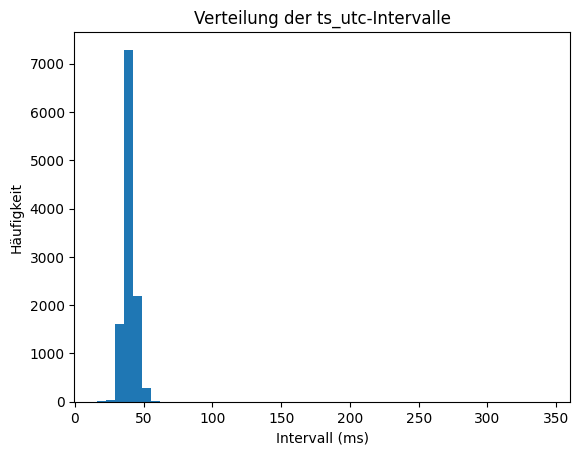

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/Users/marlenerueschoff/Documents/Uni/UzK Master/Masterarbeit/Experiment/masterthesis_experiment-1/Data/mouse_events_rows (4).csv")

# 1) ts_utc sauber in datetime mit Zeitzone (UTC) umwandeln
df["ts_utc"] = pd.to_datetime(df["ts_utc"], format="ISO8601", utc=True)

# 2) Sortieren (nur Spalten verwenden, die es gibt)
sort_cols = ["participant_id", "trial", "ts_utc"]
sort_cols = [c for c in sort_cols if c in df.columns]
df = df.sort_values(sort_cols).reset_index(drop=True)

# 3) Zeitdifferenzen in ms berechnen
group_cols = [c for c in ["participant_id", "trial"] if c in df.columns]

if group_cols:
    df["dt_ms"] = (
        df.groupby(group_cols)["ts_utc"]
          .diff()
          .dt.total_seconds() * 1000
    )
else:
    df["dt_ms"] = df["ts_utc"].diff().dt.total_seconds() * 1000

valid = df["dt_ms"].dropna()

print("Anzahl Intervalle:", len(valid))
print("Mittelwert   (ms):", valid.mean())
print("Median      (ms):", valid.median())
print("Std-Abw     (ms):", valid.std())
print("Minimum     (ms):", valid.min())
print("Maximum     (ms):", valid.max())
print(valid.quantile([0.01, 0.05, 0.5, 0.95, 0.99]))

plt.hist(valid, bins=50)
plt.xlabel("Intervall (ms)")
plt.ylabel("Häufigkeit")
plt.title("Verteilung der ts_utc-Intervalle")
plt.show()


Spalten im Datensatz:
['id', 'session_id', 'participant_id', 'task', 't_ms', 'x', 'y', 'page_w', 'page_h', 'ts_utc', 'created_at']

Anzahl NaT (nicht parsebare Zeitstempel) in ts_utc: 31

=== Grundstatistik dt_ms (in ms) ===
Anzahl Intervalle: 11394
Mittelwert      : 40.180445848692294
Median          : 40.0
Std-Abw         : 6.198018297831032
Minimum         : 16.0
Maximum         : 344.0
Perzentile:
0.01    31.0
0.05    32.0
0.50    40.0
0.95    48.0
0.99    50.0
Name: dt_ms, dtype: float64

Anteil Intervalle zwischen 30–50 ms: 98.7 %
Anteil Intervalle zwischen 35–45 ms: 77.6 %
Anteil Intervalle >= 150 ms: 0.03 %



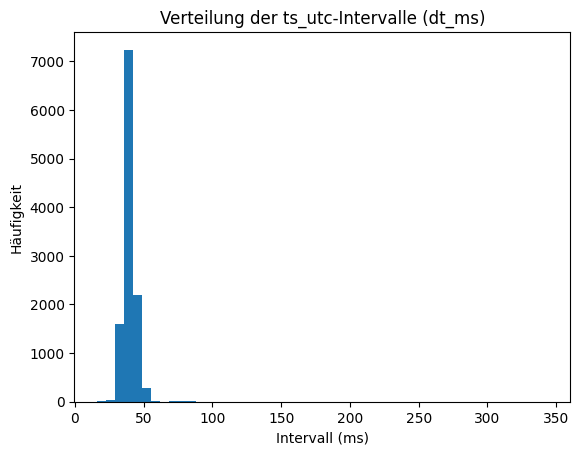

=== Monotonie-Check ===
Anzahl Intervalle mit dt < 0 ms: 0

NaN in ts_utc: 31
NaN in x: 0
NaN in y: 0

=== x/y Bereich ===
x: min = 0 max = 1487
y: min = 0 max = 925
Anzahl x außerhalb [-100, 4000]: 0
Anzahl y außerhalb [-100, 2500]: 0

=== Übersicht pro participant_id ===
                                      n_events  \
participant_id                                   
35e66184-3e42-45f7-bf6a-5d675bcac6da      1466   
4b8b5d28-8ca9-4b2d-be09-796cd60ff22f        76   
51381787-c3a4-4a69-a44d-0750124ee2ad      7809   
8e0c9b01-b81c-43c8-bb2f-35742dc5b516      2078   

                                                             min_time  \
participant_id                                                          
35e66184-3e42-45f7-bf6a-5d675bcac6da 2025-11-28 11:26:38.839000+00:00   
4b8b5d28-8ca9-4b2d-be09-796cd60ff22f 2025-11-30 13:36:34.773000+00:00   
51381787-c3a4-4a69-a44d-0750124ee2ad 2025-11-29 11:45:59.476000+00:00   
8e0c9b01-b81c-43c8-bb2f-35742dc5b516 2025-11-30 15:17:13.116

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 0) Einstellungen
# ============================================================

CSV_PATH = "/Users/marlenerueschoff/Documents/Uni/UzK Master/Masterarbeit/Experiment/masterthesis_experiment-1/Data/mouse_events_testing.csv"

# Plausibler Wertebereich für Pixelkoordinaten (anpassbar)
X_MIN_PLAUSIBLE, X_MAX_PLAUSIBLE = -100, 4000
Y_MIN_PLAUSIBLE, Y_MAX_PLAUSIBLE = -100, 2500

# Schwelle für "große Gaps" in ms (z.B. mögliche Pausen)
BIG_GAP_MS = 150.0

# ============================================================
# 1) Daten einlesen und ts_utc parsen
# ============================================================

df = pd.read_csv(CSV_PATH)

print("Spalten im Datensatz:")
print(df.columns.tolist())
print()

# ts_utc in datetime konvertieren (robust für ISO-Formate, inkl. Zeitzone)
df["ts_utc_raw"] = df["ts_utc"]  # Kopie, falls du später vergleichen willst
df["ts_utc"] = pd.to_datetime(df["ts_utc"], utc=True, errors="coerce")

print("Anzahl NaT (nicht parsebare Zeitstempel) in ts_utc:", df["ts_utc"].isna().sum())
print()

# ============================================================
# 2) Sortieren und dt_ms berechnen
# ============================================================

# Sortier- und Gruppenspalten (nur verwenden, wenn sie existieren)
sort_cols = ["participant_id", "trial", "ts_utc"]
sort_cols = [c for c in sort_cols if c in df.columns]
df = df.sort_values(sort_cols).reset_index(drop=True)

group_cols = [c for c in ["participant_id", "trial"] if c in df.columns]

if group_cols:
    df["dt_ms"] = (
        df.groupby(group_cols)["ts_utc"]
          .diff()
          .dt.total_seconds() * 1000
    )
else:
    df["dt_ms"] = df["ts_utc"].diff().dt.total_seconds() * 1000

valid_dt = df["dt_ms"].dropna()

print("=== Grundstatistik dt_ms (in ms) ===")
print("Anzahl Intervalle:", len(valid_dt))
print("Mittelwert      :", valid_dt.mean())
print("Median          :", valid_dt.median())
print("Std-Abw         :", valid_dt.std())
print("Minimum         :", valid_dt.min())
print("Maximum         :", valid_dt.max())
print("Perzentile:")
print(valid_dt.quantile([0.01, 0.05, 0.5, 0.95, 0.99]))
print()

# Verteilung in Bereichen
pct_30_50 = ((valid_dt >= 30) & (valid_dt <= 50)).mean() * 100
pct_35_45 = ((valid_dt >= 35) & (valid_dt <= 45)).mean() * 100
pct_big_gap = (valid_dt >= BIG_GAP_MS).mean() * 100

print(f"Anteil Intervalle zwischen 30–50 ms: {pct_30_50:.1f} %")
print(f"Anteil Intervalle zwischen 35–45 ms: {pct_35_45:.1f} %")
print(f"Anteil Intervalle >= {BIG_GAP_MS:.0f} ms: {pct_big_gap:.2f} %")
print()

# Histogramm der dt_ms
plt.hist(valid_dt, bins=50)
plt.xlabel("Intervall (ms)")
plt.ylabel("Häufigkeit")
plt.title("Verteilung der ts_utc-Intervalle (dt_ms)")
plt.show()

# ============================================================
# 3) Monotonie der Timestamps prüfen
# ============================================================

# Ein Intervall < 0 bedeutet: Zeitstempel nicht strikt monoton steigend
if group_cols:
    df["dt_ms_negative"] = df.groupby(group_cols)["ts_utc"].diff().dt.total_seconds() * 1000
else:
    df["dt_ms_negative"] = df["ts_utc"].diff().dt.total_seconds() * 1000

n_negative = (df["dt_ms_negative"] < 0).sum()

print("=== Monotonie-Check ===")
print("Anzahl Intervalle mit dt < 0 ms:", n_negative)

if n_negative > 0:
    print("Beispiele für nicht-monotone Timestamps:")
    print(df.loc[df["dt_ms_negative"] < 0, sort_cols + ["dt_ms_negative"]].head())
print()

# ============================================================
# 4) NaN-Checks für zentrale Spalten
# ============================================================

for col in ["ts_utc", "x", "y"]:
    if col in df.columns:
        print(f"NaN in {col}: {df[col].isna().sum()}")
print()

# ============================================================
# 5) Plausibilitäts-Check für x/y
# ============================================================

if "x" in df.columns and "y" in df.columns:
    print("=== x/y Bereich ===")
    print("x: min =", df["x"].min(), "max =", df["x"].max())
    print("y: min =", df["y"].min(), "max =", df["y"].max())

    mask_x_out = (df["x"] < X_MIN_PLAUSIBLE) | (df["x"] > X_MAX_PLAUSIBLE)
    mask_y_out = (df["y"] < Y_MIN_PLAUSIBLE) | (df["y"] > Y_MAX_PLAUSIBLE)

    print(f"Anzahl x außerhalb [{X_MIN_PLAUSIBLE}, {X_MAX_PLAUSIBLE}]:", mask_x_out.sum())
    print(f"Anzahl y außerhalb [{Y_MIN_PLAUSIBLE}, {Y_MAX_PLAUSIBLE}]:", mask_y_out.sum())
    print()

# ============================================================
# 6) Optional: Übersicht pro Teilnehmer (falls Spalte vorhanden)
# ============================================================

if "participant_id" in df.columns:
    print("=== Übersicht pro participant_id ===")
    summary = (
        df.groupby("participant_id")
          .agg(
              n_events=("ts_utc", "size"),
              min_time=("ts_utc", "min"),
              max_time=("ts_utc", "max")
          )
    )
    summary["duration_s"] = (summary["max_time"] - summary["min_time"]).dt.total_seconds()
    print(summary.head())
    print()

# ============================================================
# 7) Optional: große Gaps markieren
# ============================================================

df["big_gap"] = df["dt_ms"] >= BIG_GAP_MS
print("Anzahl Intervalle mit 'großem Gap' (>= "
      f"{BIG_GAP_MS:.0f} ms):", df["big_gap"].sum())
print()

# Wenn du sehen willst, wo die großen Gaps auftreten:
if df["big_gap"].any():
    cols_to_show = [c for c in ["participant_id", "trial", "ts_utc", "dt_ms"] if c in df.columns]
    print("Beispiele für große Gaps:")
    print(df.loc[df["big_gap"], cols_to_show].head())


# Submovements + Deviation

Hyperparameters
ROLL_WIN_SAMPLES = Size of the centered moving average applied to the speed series before finding peaks 
-> Typical: 3–5 (with ~40 ms sampling, that’s ~120–200 ms smoothing).
-> Effect:
    Larger → smoother curve, fewer peaks.
    Smaller → noisier curve, more peaks.

MIN_PROMINENCE_PX_S = How much higher a peak must be relative to its immediate left/right valleys.
-> Start around the 20th–40th percentile of non-zero speeds.
-> Effect:
    Larger → suppresses small/flat bumps → fewer, more salient peaks.
    Smaller → allows small bumps → more peaks, including noise.

MIN_PEAK_HEIGHT_PX_S = absolute minimum peak height, px/s
-> Typical: Just above your noise floor, e.g., median(speed when moving slowly) or P10–P20 of all positive speeds.
-> Effect:
    Larger → discards slow, possibly jitter-based peaks.
    Smaller → admits slow “peaks” → risk of false positives during tiny moves.

MIN_PEAK_DISTANCE_MS = Minimum elapsed time between accepted peaks
-> Typical: 200 ms (aligns with your pause notion); range 120–300 ms.
-> Effect:
    Larger → merges nearby peaks → fewer but longer submovements.
    Smaller → allows rapid successive peaks → more submovements.

In [30]:
# =============================================================================
# 0) Peak detection hyperparameters
# =============================================================================
ROLL_WIN_SAMPLES      = 3      # ~120 ms if sampling interval is ~40 ms
MIN_PROMINENCE_PX_S   = 50.0   # required prominence of a speed peak (tune on data)
MIN_PEAK_HEIGHT_PX_S  = 50.0   # minimum peak speed to count as submovement (px/s)
MIN_PEAK_DISTANCE_MS  = 200    # minimum time between two peaks (ms; refractory period)


# =============================================================================
# 1) Helper functions
# =============================================================================

def _moving_avg(a: np.ndarray, win: int) -> np.ndarray:
    """
    Compute a simple centered moving average over a 1D array.

    Parameters
    ----------
    a : np.ndarray
        Input array (e.g., speed over time).
    win : int
        Window length. If win <= 1, the original array is returned.

    Returns
    -------
    np.ndarray
        Smoothed array of the same length as `a`.
    """
    if win <= 1:
        return a
    return (
        pd.Series(a, dtype="float64")
        .rolling(win, center=True, min_periods=1)
        .mean()
        .to_numpy()
    )


def _compute_speed_px_s_aligned(g: pd.DataFrame) -> np.ndarray:
    """
    Compute pointwise speed (px/s) for a trajectory DataFrame, aligned to g.index.

    Uses:
    - finite forward differences in x, y
    - time differences in milliseconds

    Any time differences that are non-finite or <= 0 are treated as invalid,
    and the corresponding speed entries are set to NaN.

    Parameters
    ----------
    g : pd.DataFrame
        DataFrame with at least columns 'x', 'y', 't_ms'.

    Returns
    -------
    np.ndarray
        Speed in px/s, same length as g, with NaN for the first row
        and invalid time steps.
    """
    dx   = g["x"].diff().to_numpy(dtype="float64")
    dy   = g["y"].diff().to_numpy(dtype="float64")
    dt_s = (g["t_ms"].diff() / 1000.0).to_numpy(dtype="float64")

    # Euclidean distance between consecutive samples
    dist = np.sqrt(dx * dx + dy * dy)

    # Mark invalid time intervals before division
    invalid = ~np.isfinite(dt_s) | (dt_s <= 0)

    # Pre-allocate speed array
    v = np.empty_like(dt_s, dtype="float64")
    v[:] = np.nan

    ok = ~invalid
    v[ok] = dist[ok] / dt_s[ok]  # px/s for valid intervals

    # The first row remains NaN (no previous sample)
    return v


def _find_speed_peaks(
    v_smooth: np.ndarray,
    t_ms: np.ndarray,
    min_prominence: float,
    min_height: float,
    min_peak_distance_ms: float
) -> np.ndarray:
    """
    Detect local maxima (speed peaks) in a smoothed speed signal.

    A peak is accepted if:
    - it is a local maximum compared to its immediate neighbors,
    - its value >= min_height,
    - its prominence relative to neighbors >= min_prominence,
    - it is at least min_peak_distance_ms after the last accepted peak.

    Parameters
    ----------
    v_smooth : np.ndarray
        Smoothed speed (px/s).
    t_ms : np.ndarray
        Timestamps in milliseconds, same length as v_smooth.
    min_prominence : float
        Minimum prominence relative to neighbors.
    min_height : float
        Minimum absolute height of the peak (px/s).
    min_peak_distance_ms : float
        Minimum time between two accepted peaks in ms.

    Returns
    -------
    np.ndarray
        Array of indices (into v_smooth / original trajectory) where peaks occur.
    """
    peaks = []
    n = len(v_smooth)
    last_peak_time = -np.inf

    for i in range(1, n - 1):
        vi = v_smooth[i]
        if not np.isfinite(vi):
            continue

        # Neighbor values (fall back to -inf if NaN)
        left_val  = v_smooth[i - 1] if np.isfinite(v_smooth[i - 1]) else -np.inf
        right_val = v_smooth[i + 1] if np.isfinite(v_smooth[i + 1]) else -np.inf

        # Local maximum check
        if vi <= left_val:
            continue
        if vi <= right_val:
            continue

        # Minimum height check
        if vi < min_height:
            continue

        # Prominence relative to neighbors
        prom = vi - max(left_val, right_val)
        if prom < min_prominence:
            continue

        # Enforce minimum temporal distance between peaks
        if (t_ms[i] - last_peak_time) < min_peak_distance_ms:
            continue

        peaks.append(i)
        last_peak_time = t_ms[i]

    return np.array(peaks, dtype=int)


def _compute_submovement_deviations(g: pd.DataFrame, peaks: np.ndarray) -> list[float]:
    """
    Compute submovement deviations for a set of peaks within one trajectory.

    Each submovement is defined as the segment between peak k and peak k+1.
    For each segment:
        deviation = actual path length / straight-line distance

    Parameters
    ----------
    g : pd.DataFrame
        DataFrame for a single group/trajectory, with columns 'x', 'y'.
    peaks : np.ndarray
        Indices of detected speed peaks (into g).

    Returns
    -------
    list[float]
        Deviation values for all submovement segments (may contain NaNs).
    """
    x = g["x"].to_numpy(dtype="float64")
    y = g["y"].to_numpy(dtype="float64")

    devs: list[float] = []

    # Build segments between successive peaks: [peaks[k], peaks[k+1]]
    for k in range(len(peaks) - 1):
        i0 = peaks[k]
        i1 = peaks[k + 1]
        if i1 <= i0:
            continue

        xs = x[i0:i1 + 1]
        ys = y[i0:i1 + 1]

        # Actual path length
        dx = np.diff(xs)
        dy = np.diff(ys)
        actual_dist = np.sum(np.sqrt(dx * dx + dy * dy))

        # Straight-line distance (start to end)
        shortest_dist = np.sqrt((xs[-1] - xs[0])**2 + (ys[-1] - ys[0])**2)

        if shortest_dist > 0:
            devs.append(actual_dist / shortest_dist)
        else:
            devs.append(np.nan)

    return devs


# =============================================================================
# 2) Core per-group computation
# =============================================================================

def _count_submovements_speed_peaks(
    g: pd.DataFrame,
    roll_win: int = ROLL_WIN_SAMPLES,
    min_prom: float = MIN_PROMINENCE_PX_S,
    min_height: float = MIN_PEAK_HEIGHT_PX_S,
    min_dist_ms: float = MIN_PEAK_DISTANCE_MS
) -> pd.DataFrame:
    """
    Compute submovement metrics for a single group/trajectory `g` using speed peaks.

    Steps:
    1. Sort by time and clean numeric columns.
    2. Compute or reuse speed ('speed_px_s').
    3. Smooth the speed signal.
    4. Detect peaks in smoothed speed.
    5. Derive:
        - number of submovements,
        - trial duration,
        - submovements per second,
        - mean submovement deviation.

    Parameters
    ----------
    g : pd.DataFrame
        Single group of mouse data, containing at least 't_ms', 'x', 'y'.
        If 'speed_px_s' is present, it will be reused.
    roll_win : int
        Window length for moving average smoothing.
    min_prom : float
        Minimum prominence of a peak.
    min_height : float
        Minimum absolute height of a peak.
    min_dist_ms : float
        Minimum time between peaks in ms.

    Returns
    -------
    pd.DataFrame
        One-row DataFrame with:
        - submovements
        - trial_duration_ms
        - submovements_per_s
        - mean_submovement_deviation
    """
    # Ensure sorted by time and numeric types
    g = g.sort_values("t_ms").reset_index(drop=True)
    g["t_ms"] = pd.to_numeric(g["t_ms"], errors="coerce")
    g["x"]    = pd.to_numeric(g["x"],  errors="coerce")
    g["y"]    = pd.to_numeric(g["y"],  errors="coerce")
    g = g.dropna(subset=["t_ms", "x", "y"])

    # If too few samples, we cannot detect peaks reliably
    if len(g) < 3:
        if len(g):
            dur = float(g["t_ms"].iloc[-1] - g["t_ms"].iloc[0])
        else:
            dur = np.nan

        rate = (0 / (dur / 1000.0)) if (np.isfinite(dur) and dur > 0) else np.nan
        return pd.DataFrame(
            {
                "submovements": [0],
                "trial_duration_ms": [dur],
                "submovements_per_s": [rate],
                "mean_submovement_deviation": [np.nan],
            }
        )

    # Reuse existing speed if present; otherwise compute fresh
    if "speed_px_s" in g.columns and g["speed_px_s"].notna().any():
        v = g["speed_px_s"].to_numpy(dtype="float64")
        v[~np.isfinite(v)] = np.nan
    else:
        v = _compute_speed_px_s_aligned(g)

    t_ms = g["t_ms"].to_numpy(dtype="float64")

    # Smooth speed
    v_s = _moving_avg(v, roll_win)

    # Detect peaks in smoothed speed
    peaks = _find_speed_peaks(
        v_s,
        t_ms,
        min_prominence=min_prom,
        min_height=min_height,
        min_peak_distance_ms=min_dist_ms,
    )

    submoves = int(peaks.size)
    dur = float(t_ms[-1] - t_ms[0])
    rate = submoves / (dur / 1000.0) if (np.isfinite(dur) and dur > 0) else np.nan

    # Submovement deviation is only defined if we have at least one segment
    # (i.e., at least 2 peaks)
    if submoves >= 2:
        devs = _compute_submovement_deviations(g, peaks)
        mean_dev = np.nanmean(devs) if len(devs) else np.nan
    else:
        mean_dev = np.nan

    return pd.DataFrame(
        {
            "submovements": [submoves],
            "trial_duration_ms": [dur],
            "submovements_per_s": [rate],
            "mean_submovement_deviation": [mean_dev],
        }
    )


# =============================================================================
# 3) Public API functions
# =============================================================================

def submovements_per_trial_speed_peaks(
    df_mouse: pd.DataFrame,
    group_cols
) -> pd.DataFrame:
    """
    Compute submovement metrics per trial (or per group-cols combination).

    Parameters
    ----------
    df_mouse : pd.DataFrame
        Full mouse trajectory data containing at least:
        - 't_ms', 'x', 'y', and all columns listed in `group_cols`.
    group_cols : sequence of str
        Columns that define a group/trial, e.g. ('participant_id', 'trial_id').

    Returns
    -------
    pd.DataFrame
        One row per group with columns:
        - group_cols
        - submovements
        - trial_duration_ms
        - submovements_per_s
        - mean_submovement_deviation
    """
    needed = set(group_cols) | {"t_ms", "x", "y"}
    missing = [c for c in needed if c not in df_mouse.columns]
    if missing:
        raise KeyError(f"df_mouse is missing required columns: {missing}")

    # Group by the trial definition
    gobj = df_mouse.groupby(list(group_cols), dropna=False)

    # Apply per-group computation
    out = gobj.apply(lambda g: _count_submovements_speed_peaks(g))

    # Move group keys back into columns
    out = out.reset_index()

    # Clean up any potential 'level_*' columns introduced by groupby/apply
    out = out.drop(
        columns=[c for c in out.columns if c.startswith("level_")],
        errors="ignore",
    )

    return out


def submovements_per_participant_speed_peaks(
    df_mouse: pd.DataFrame,
    group_cols
):
    """
    Compute submovement metrics per group (per_trial) and aggregate to participant level.

    Notes
    -----
    - If group_cols = ('participant_id',), then each "trial" is effectively a
      participant-level trajectory (no within-participant trial structure).
    - If you include an additional trial column, e.g. ('participant_id', 'trial_id'),
      then the per_trial DataFrame is truly per trial, and aggregation will
      combine over all trials per participant.

    Parameters
    ----------
    df_mouse : pd.DataFrame
        Mouse trajectory data.
    group_cols : sequence of str
        Columns that define each trial group (must include participant_id).

    Returns
    -------
    per_trial : pd.DataFrame
        Output of submovements_per_trial_speed_peaks.
    agg : pd.DataFrame
        Participant-level summary with columns:
        - participant_id (or first element of group_cols)
        - total_submovements
        - total_trial_time_ms
        - mean_dev_over_trials
        - submovements_per_s
    """
    # First compute submovements per group/trial
    per_trial = submovements_per_trial_speed_peaks(df_mouse, group_cols=group_cols)

    # Identify participant column
    part_col = "participant_id" if "participant_id" in group_cols else group_cols[0]

    # Aggregate per participant
    agg = (
        per_trial.groupby(part_col, as_index=False)
        .agg(
            total_submovements=("submovements", "sum"),
            total_trial_time_ms=("trial_duration_ms", "sum"),
            mean_dev_over_trials=("mean_submovement_deviation", "mean"),
        )
    )

    # Overall submovement rate per second, across all trials for each participant
    agg["submovements_per_s"] = agg["total_submovements"] / (
        agg["total_trial_time_ms"] / 1000.0
    )

    return per_trial, agg


per_trial, agg = submovements_per_participant_speed_peaks(df_mouse_with_steps, group_cols=GROUPING,)

print("Per-trial (first 10 rows):")
print(per_trial.head(10))

print("\nPer-participant (first 10 rows):")
print(agg.head(10))


Per-trial (first 10 rows):
                         participant_id  submovements  trial_duration_ms  \
0  35e66184-3e42-45f7-bf6a-5d675bcac6da            21            58765.0   
1  4b8b5d28-8ca9-4b2d-be09-796cd60ff22f             2             3361.0   
2  51381787-c3a4-4a69-a44d-0750124ee2ad           103           312600.0   
3  8e0c9b01-b81c-43c8-bb2f-35742dc5b516            27            83094.0   

   submovements_per_s  mean_submovement_deviation  
0            0.357356                    3.561581  
1            0.595061                    1.251442  
2            0.329495                    2.404260  
3            0.324933                    1.584670  

Per-participant (first 10 rows):
                         participant_id  total_submovements  \
0  35e66184-3e42-45f7-bf6a-5d675bcac6da                  21   
1  4b8b5d28-8ca9-4b2d-be09-796cd60ff22f                   2   
2  51381787-c3a4-4a69-a44d-0750124ee2ad                 103   
3  8e0c9b01-b81c-43c8-bb2f-35742dc5b516       

/var/folders/v_/5q_t13ds7pz7yhp0h3fhnrr40000gn/T/ipykernel_38998/3353622450.py:359: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = gobj.apply(lambda g: _count_submovements_speed_peaks(g))


# Submovement Deviation